In [338]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from math import sqrt
import time
import seaborn as sns
sns.set()

In [339]:
rawData = pd.read_csv("CommViolPredUnnormalizedData.txt", sep=",", header=None)
rawData.replace(to_replace = '?',value=np.nan,inplace=True)
rawData.shape

def readColumnNames(path):
    with open (path) as myfile:
        lines = myfile.readlines()              
    
    columnNames = []
    for line in lines:
        lineParts = str(line).split(":",2)
        columnName = lineParts[0].split(" ", 2)
        columnNames.append(columnName[1])
    return columnNames

#add columnn headers to raw dataset:
columnHeaders = readColumnNames("ColumnNames.txt")
rawData.columns = columnHeaders

According to the documentation the first five (0-4) columns are information only:

communityname: Community name - not predictive - for information only (string) <br>
state: US state (by 2 letter postal abbreviation)(nominal)<br>
countyCode: numeric code for county - not predictive, and many missing values (numeric)<br>
communityCode: numeric code for community - not predictive and many missing values (numeric)<br>
fold: fold number for non-random 10 fold cross validation, potentially useful for debugging, paired tests - not predictive (numeric - integer) <br>

and do not help with the crime rate prediction, therefore i will drop them from the raw dataset table

In [340]:
#dropping the first five columns:
rawData.drop(columns=["communityname", "state", "countyCode", "communityCode", "fold"], axis=1, inplace=True)


#the row with the most missing values has 30 missing values (out of 147)
#print("Row with most missing values:", rawData.isnull().sum(axis=1).max())
#print("Column with most missing values:")

booleanColumnsMissingValues = rawData.isnull().sum(axis=0).apply(lambda x: x > 1500).values
filteredColumns = []
for i,j in zip(rawData.columns, booleanColumnsMissingValues):
      if j:
            filteredColumns.append(i)
print("The following columns had more than 100 missing values (from a  total of 2215 rows, so thats over 65%, therefore we are removing those columns: \n", filteredColumns)
rawData.drop(filteredColumns, axis=1, inplace=True)

The following columns had more than 100 missing values (from a  total of 2215 rows, so thats over 65%, therefore we are removing those columns: 
 ['LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop']


In [341]:
rawData.shape

# get the rows with the most missing values and  drop them:
#turns out there are just a few rows with more than (or equal to) 5 missing values, the maximum is 6. Most common one is 3
missingValuesRows = rawData.isnull().sum(axis=1)
missingValuesRows = (missingValuesRows[np.argsort(missingValuesRows)[::-1]]>=5)
missingValuesRowsIndexes = [i for i, x in zip(missingValuesRows.index,missingValuesRows.values) if x]
rawData.drop(missingValuesRowsIndexes, axis=0, inplace=True)


#remove rows where our target feature has missing values:

missingValuesTarget = rawData['ViolentCrimesPerPop'].isnull()
missingValuesTargetIndices = []
for k,i in enumerate(missingValuesTarget):
    if i:
        missingValuesTargetIndices.append(k)
        
rawData = rawData.drop(rawData.index[missingValuesTargetIndices])
print("Now there are no more rows where our target value is missing: ", rawData['ViolentCrimesPerPop'].isnull().sum())


Now there are no more rows where our target value is missing:  0


<b>since we want to predict the total number of violent crimes per population, we will drop the following attributes:</b> <br>
-- murders: number of murders in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted) <br>
-- murdPerPop: number of murders per 100K population (numeric - decimal) potential GOAL attribute (to be predicted)<br>
-- rapes: number of rapes in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted )<br>
-- rapesPerPop: number of rapes per 100K population (numeric - decimal) potential GOAL attribute (to be predicted)<br>
-- robberies: number of robberies in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted)<br>
-- robbbPerPop: number of robberies per 100K population (numeric - decimal) potential GOAL attribute (to be predicted)<br>
-- assaults: number of assaults in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted)<br>
-- assaultPerPop: number of assaults per 100K population (numeric - decimal) potential GOAL attribute (to be predicted)<br>
-- burglaries: number of burglaries in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted)<br>
-- burglPerPop: number of burglaries per 100K population (numeric - decimal) potential GOAL attribute (to be predicted)<br>
-- larcenies: number of larcenies in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted)<br>
-- larcPerPop: number of larcenies per 100K population (numeric - decimal) potential GOAL attribute (to be predicted)<br>
-- autoTheft: number of auto thefts in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted)<br>
-- autoTheftPerPop: number of auto thefts per 100K population (numeric - decimal) potential GOAL attribute (to be predicted)<br>
-- arsons: number of arsons in 1995 (numeric - expected to be integer) potential GOAL attribute (to be predicted)<br>
-- arsonsPerPop: number of arsons per 100K population (numeric - decimal) potential GOAL attribute (to be predicted)<br> 

In [342]:
rawData = rawData.drop(["murders","murdPerPop","rapes","rapesPerPop", "robberies", "robbbPerPop", "assaults", "assaultPerPop", "burglaries",
             "burglPerPop","larcenies","larcPerPop","autoTheft","autoTheftPerPop","arsons","arsonsPerPop"], axis=1)
print(rawData.shape)

(1991, 104)


In [335]:
#Imputing missing values:
rawData = rawData.apply(pd.to_numeric)
rawData = rawData.fillna(rawData.mean())
tmpList = rawData.isnull().sum(axis=0)
#tmpList[np.argsort(tmpList)][::-1]

In [280]:
#correlation: ViolentCrimesPerPop
correlationRaw = rawData.corr()['ViolentCrimesPerPop']
#print(correlationRaw[np.argsort(abs(correlationRaw))[::-1]])

In [336]:
#scaling/normalizing:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(rawData)
rawData_temp = pd.DataFrame(scaler.transform(rawData))
rawData_temp.columns = rawData.columns


rawData.to_csv("CrimeWeka.csv", sep=",", index=False)

''' 
Some Plots:
rawData.plot(x='ViolentCrimesPerPop', y='PctKidsBornNeverMar', style='o')
rawData.plot(x='ViolentCrimesPerPop', y='PctKids2Par', style='o')
rawData.plot(x='ViolentCrimesPerPop', y='PctFam2Par', style='o')
rawData.plot(x='ViolentCrimesPerPop', y='racePctWhite', style='o')
rawData.plot(x='ViolentCrimesPerPop', y='PctYoungKids2Par', style='o')
rawData.plot(x='ViolentCrimesPerPop', y='PctTeen2Par', style='o')
rawData.plot(x='ViolentCrimesPerPop', y='nonViolPerPop', style='o')
rawData.plot(x='ViolentCrimesPerPop', y='racepctblack', style='o')
'''

" \nSome Plots:\nrawData.plot(x='ViolentCrimesPerPop', y='PctKidsBornNeverMar', style='o')\nrawData.plot(x='ViolentCrimesPerPop', y='PctKids2Par', style='o')\nrawData.plot(x='ViolentCrimesPerPop', y='PctFam2Par', style='o')\nrawData.plot(x='ViolentCrimesPerPop', y='racePctWhite', style='o')\nrawData.plot(x='ViolentCrimesPerPop', y='PctYoungKids2Par', style='o')\nrawData.plot(x='ViolentCrimesPerPop', y='PctTeen2Par', style='o')\nrawData.plot(x='ViolentCrimesPerPop', y='nonViolPerPop', style='o')\nrawData.plot(x='ViolentCrimesPerPop', y='racepctblack', style='o')\n"

In [257]:
y = rawData_temp['ViolentCrimesPerPop'].values
X = rawData_temp.drop('ViolentCrimesPerPop', axis=1).values
#first model, linear regression as baseline:
kf = KFold(n_splits=10)
scores = []

c = 20
pca = PCA(n_components = c)
X = pca.fit_transform(X)


for train_index, test_index in kf.split(X):
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     reg = Lasso(alpha=0.01).fit(X_train, y_train)
     y_pred = reg.predict(X_test)
     scores.append(r2_score(y_test, y_pred))
     print("R2 Score: ", r2_score(y_test, y_pred))
     print("MSE Score: ", mean_squared_error(y_test, y_pred))
     print("MAE Score: ", mean_absolute_error(y_test, y_pred))

print("mean r2 score: ", np.mean(scores))


R2 Score:  0.6379392641822728
MSE Score:  0.778430026550345
MAE Score:  0.5586790265103206
R2 Score:  0.6510236896948771
MSE Score:  0.5590790411828229
MAE Score:  0.5292322350946047
R2 Score:  0.6141823815891783
MSE Score:  0.5303044851675212
MAE Score:  0.5161073660737253
R2 Score:  0.6466737666634361
MSE Score:  0.7586541627999084
MAE Score:  0.5739486682687212
R2 Score:  0.6010444540342117
MSE Score:  0.6152071180817008
MAE Score:  0.49264683096616885
R2 Score:  0.6644838187135411
MSE Score:  0.490966780054747
MAE Score:  0.4768672170585915
R2 Score:  0.6556277390536223
MSE Score:  0.4068446149913176
MAE Score:  0.47344754462463684
R2 Score:  0.6599211885208209
MSE Score:  0.5607706733981889
MAE Score:  0.5048073090842806
R2 Score:  0.591523550661138
MSE Score:  0.5935151689861579
MAE Score:  0.5122902621713143
R2 Score:  0.5540422887835432
MSE Score:  0.5438377888741984
MAE Score:  0.5071389754781382
mean r2 score:  0.6276462141896643


In [296]:
from sklearn.model_selection import cross_validate
def evaluater(classifier, Xdata, Ydata, scoring = ["explained_variance", "r2" ,"neg_mean_squared_error", "neg_mean_absolute_error"], cv=10):
    #explained variance: how many percent of the variance are explained?
    #r^2: How many percent of the absolut squared error are explained
    np.random.seed(0)
    results = cross_validate(classifier, Xdata, Ydata, scoring = scoring, cv=cv, return_train_score=False)
    rval = {}
    for i in results:
        rval[i] =  results[i].mean()
    for i in ["test_neg_mean_squared_error", "test_neg_mean_absolute_error"]:
        if rval[i] < 0:
            rval[i] = rval[i]*-1
    return rval



Amount of variance: [24.65927283 16.31501018  9.20332244  7.93173925  6.43540856  4.40062965
  3.5732674   2.99237123  2.17134146  1.64339859  1.60177806  1.48743905
  1.47045813  1.10037662]
Sum of the variance: 84.99
Percentage of variance: [0.23929017 0.1583186  0.08930777 0.0769685  0.06244831 0.0427031
 0.03467449 0.02903756 0.0210704  0.01594731 0.01554343 0.0144339
 0.01426912 0.0106779 ]
Sum of the percentage of variance: 0.82


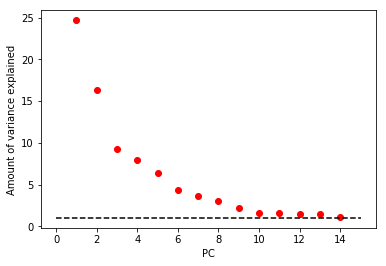

(1991, 14)


In [162]:
#Using PCA for dimensionality reduction:
'''
y = rawData['ViolentCrimesPerPop']
X = rawData.drop('ViolentCrimesPerPop', axis=1).values

c = 14
pca = PCA(n_components = c)
X = pca.fit_transform(X)

print("Amount of variance: %s" % pca.explained_variance_)
print("Sum of the variance: %s" % sum(pca.explained_variance_).round(2))

print("Percentage of variance: %s" % pca.explained_variance_ratio_)
print("Sum of the percentage of variance: %s" % sum(pca.explained_variance_ratio_).round(2))


plt.scatter(np.arange(1,(c+1)),pca.explained_variance_, c = 'red')
plt.plot((0,15), (1,1), color = 'black', linestyle = 'dashed')
plt.xlabel('PC')
plt.ylabel('Amount of variance explained')
plt.show()
print(X.shape)
'''

In [345]:
def calculate_models(rawData, scaling="minmax", pca_ind=True, pca_c=14, imputing="mean"):
    #imputing missing values:
    rawData = rawData.apply(pd.to_numeric)
    if(imputing=="mean"):
        rawData = rawData.fillna(rawData.mean())
    if(imputing=="median"):
        rawData = rawData.apply(pd.to_numeric)
        rawData = rawData.fillna(rawData.median())
    if(imputing=="mostFrequent"):
        imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
        imp.fit(rawData)
        rawData_tmp2 = pd.DataFrame(imp.transform(rawData))
        rawData_tmp2.colums = rawData.columns
        rawData = rawData_tmp2
    
    #scaling:
    if(scaling=="minmax"):
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(rawData)
        rawData_temp = pd.DataFrame(scaler.transform(rawData))
        rawData_temp.columns = rawData.columns
        rawData = rawData_temp
    if(scaling =="standard"):
        scaler = StandardScaler()
        scaler.fit(rawData)
        rawData_temp = pd.DataFrame(scaler.transform(rawData))
        rawData_temp.columns = rawData.columns
        rawData = rawData_temp
    
    #splitting into X and y:
    y = rawData_temp['ViolentCrimesPerPop'].values
    X = rawData_temp.drop('ViolentCrimesPerPop', axis=1).values
    
    #applying PCA
    if(pca_ind):
        pca = PCA(n_components = pca_c)
        X = pca.fit_transform(X)

    #applying GridSearch:
    models = [LinearRegression(), SGDRegressor(), Lasso(), Ridge(), neighbors.KNeighborsRegressor()]

    parameters = [{},
                 {'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 
                  'penalty' : ['none', 'l2', 'l1', 'elasticnet'],
                  'max_iter': [10,100,1000,10000] 
                 },
                  {'alpha':[0.0001,0.001,0.01,0.1]
                 },
                  {'alpha':[0.0001,0.001,0.01,0.1]
                 },
                  {'n_neighbors':[2,4,8,10,12,14,16,18,20,25,30], 'weights':['uniform','distance']}
                 ]

    for i,m in enumerate(models):
        start_time = time.time()
        grid_obj = GridSearchCV(m, parameters[i])
        grid_obj = grid_obj.fit(X, y)
        m = grid_obj.best_estimator_
        print(m)
        #print(evaluater(m, X, y))
        kf = KFold(n_splits=10)
        scores_r2 = []
        scores_MAE = []
        scores_MSE = []
        scores_RAE = [] #relative absolute error
        scores_RMSE = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            m.fit(X_train,y_train)
            y_pred = m.predict(X_test)
            scores_r2.append(r2_score(y_test, y_pred))
            scores_MAE.append(mean_absolute_error(y_test, y_pred))
            scores_MSE.append(mean_squared_error(y_test, y_pred))
            scores_RMSE.append(sqrt(mean_squared_error(y_test, y_pred)))
        print("R2: ", np.mean(scores_r2))
        print("MAE: ", np.mean(scores_MAE))
        print("MSE: ", np.mean(scores_MSE))
        print("RMSE: ", np.mean(scores_RMSE))
        print("------------------------ %s seconds --------------------------------------------" % (time.time() - start_time))
        

    #evaluater(classifier, Xdata, Ydata, scoring = ["explained_variance", "r2" ,"neg_mean_squared_error", "neg_mean_absolute_error"], cv=10)

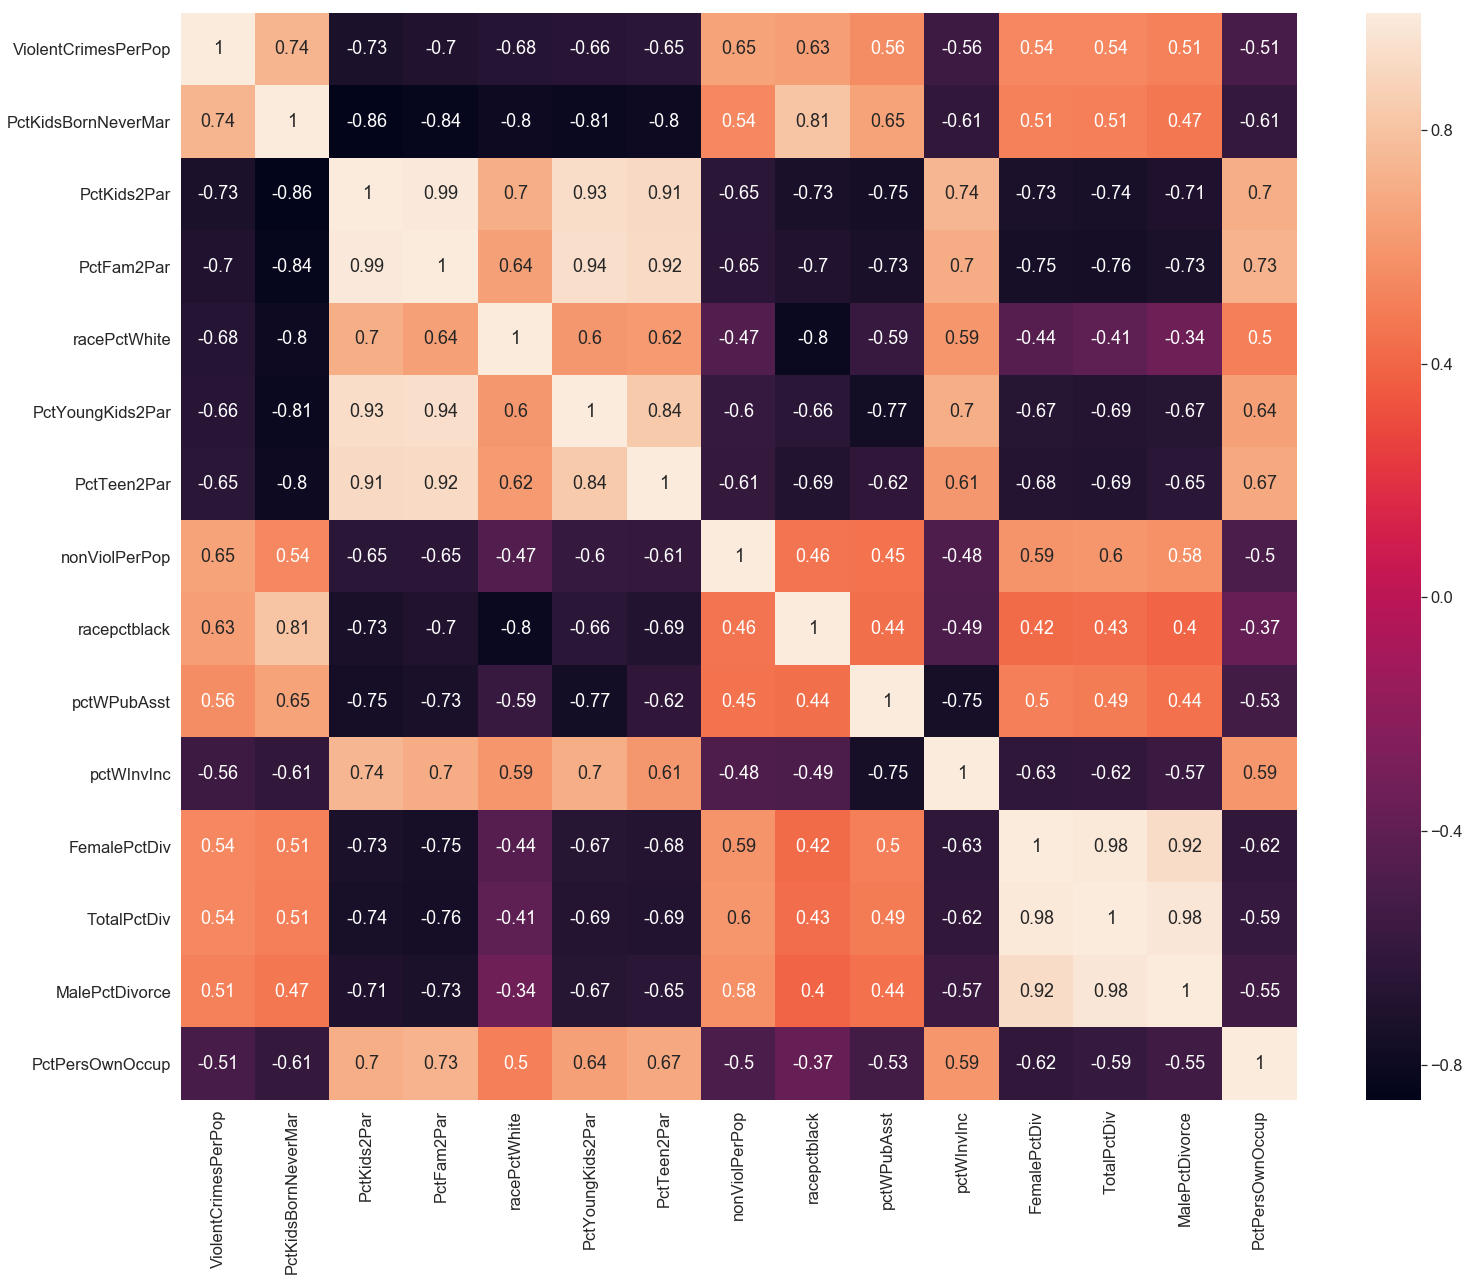

In [329]:
#plotting the distribution of the most corrolated features:

def plot_feature_class_distribution(tt, features):
    plt.figure(figsize=(46, 36))
    for i, col in enumerate(features):
            plt.subplot(4, 3, i+1)
            plt.hist(tt[col], color='blue', bins=100)
            plt.title(col)
    plt.show()
    
def plot_feature_class_diagram(tt, features):
    plt.figure(figsize=(46, 36))
    for i, col in enumerate(features):
            plt.subplot(4, 3, i+1)
            plt.plot(tt['ViolentCrimesPerPop'], tt[col],  'ro')
            plt.title(col)
    plt.show()
    
correlationRaw = rawData.corr()['ViolentCrimesPerPop']
#print(correlationRaw[np.argsort(abs(correlationRaw))[::-1]])
correlationRaw = correlationRaw[np.argsort(abs(correlationRaw))[::-1]]
#print(correlationRaw.index[1:15])
#plot_feature_class_distribution(rawData, correlationRaw.index[1:13])
#plot_feature_class_diagram(rawData, correlationRaw.index[1:13])

#plotting a heatmap:
heatmap_df = pd.DataFrame()
for i in correlationRaw.index[0:15]:
    heatmap_df[i] = rawData[i]
    

plt.figure(figsize=(25,20))
sns.set(font_scale=1.5)
sns.heatmap(heatmap_df.corr(),annot=True);


In [346]:
print("scaling=minmax, pca_ind=True, pca_c=14, imputing=mean")
calculate_models(rawData, scaling="minmax", pca_ind=True, pca_c=14, imputing="mean")

print("scaling=minmax, pca_ind=True, pca_c=14, imputing=median")
calculate_models(rawData, scaling="minmax", pca_ind=True, pca_c=14, imputing="median")

#print("scaling=minmax, pca_ind=True, pca_c=14, imputing=most_frequent")
#calculate_models(rawData, scaling="minmax", pca_ind=True, pca_c=14, imputing="mostFrequent")
    
print("scaling=minmax, pca_ind=False, pca_c=0, imputing=mean")
calculate_models(rawData, scaling="minmax", pca_ind=False, pca_c=0, imputing="mean")

print("scaling=minmax, pca_ind=False, pca_c=0, imputing=median")
calculate_models(rawData, scaling="minmax", pca_ind=False, pca_c=0, imputing="median")

#print("scaling=minmax, pca_ind=False, pca_c=0, imputing=most_frequent")
#calculate_models(rawData, scaling="minmax", pca_ind=False, pca_c=0, imputing="mostFrequent")

print("scaling=standard, pca_ind=True, pca_c=14, imputing=mean")
calculate_models(rawData, scaling="standard", pca_ind=True, pca_c=14, imputing="mean")

print("scaling=standard, pca_ind=True, pca_c=14, imputing=median")
calculate_models(rawData, scaling="standard", pca_ind=True, pca_c=14, imputing="median")

#print("scaling=standard, pca_ind=True, pca_c=14, imputing=most_frequent")
#calculate_models(rawData, scaling="standard", pca_ind=True, pca_c=14, imputing="mostFrequent")

print("scaling=standard, pca_ind=False, pca_c=0, imputing=mean")
calculate_models(rawData, scaling="standard", pca_ind=False, pca_c=0, imputing="mean")

print("scaling=standard, pca_ind=False, pca_c=0, imputing=median")
calculate_models(rawData, scaling="standard", pca_ind=False, pca_c=0, imputing="median")

#print("scaling=standard, pca_ind=False, pca_c=0, imputing=most_frequent")
#calculate_models(rawData, scaling="standard", pca_ind=False, pca_c=0, imputing="mostFrequent")


scaling=minmax, pca_ind=True, pca_c=14, imputing=mean
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
R2:  0.6109306560118016
MAE:  0.05274322142129315
MSE:  0.0061021808170681
RMSE:  0.07779013966359431
------------------------ 0.01894998550415039 seconds --------------------------------------------
SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=100, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
R2:  0.6108824185219268
MAE:  0.05274673853838492
MSE:  0.006103539568150273
RMSE:  0.07779795139710038
------------------------ 89.68596768379211 seconds --------------------------------------------
Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=12, p=2,
          weights='distance')
R2:  0.6082593380092741
MAE:  0.3998291496740219
MSE:  0.38926535289384734
RMSE:  0.6208205369075499
------------------------ 3.787679672241211 seconds --------------------------------------------
scaling=standard, pca_ind=True, pca_c=14, imputing=median
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
R2:  0.5919248462336629
MAE:  0.41160160115766714
MSE:  0.4177154570971159
RMSE:  0.6324143392505011
------------------------ 0.015620946884155273 seconds --------------------------------------------
SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='huber', max_iter=10, n_iter=None, penalty='elasticnet',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
R2:  0.6667745067418933
MAE:  0.3729873059490637
MSE:  0.33422546954403026
RMSE:  0.5723855322993863
------------------------ 0.5529623031616211 seconds --------------------------------------------
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
R2:  0.5914449945434173
MAE:  0.3915943026099509
MSE:  0.43132356601764704
RMSE:  0.625224010234731
------------------------ 0.15932178497314453 seconds --------------------------------------------
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=16, p=2,
          weights='distance')
R2:  0.6040074254707611
MAE:  0.395308585269019
MSE:  0.3958736657264078
RMSE:  0.6248314989778635
--------------------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
R2:  0.6658326714868681
MAE:  0.3730220148465187
MSE:  0.335165569084612
RMSE:  0.5732015522198515
------------------------ 0.6334657669067383 seconds --------------------------------------------
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
R2:  0.5901531934513368
MAE:  0.39170572776908574
MSE:  0.43283013825313654
RMSE:  0.6261233809141433
------------------------ 0.3229391574859619 seconds --------------------------------------------
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=16, p=2,
          weights='distance')
R2:  0.6036548726758164
MAE:  0.39541880432395776
MSE:  0.39620197365490684
RMSE:  0.6251235962705823
------------------